#### **CARTPOLE DDQN  (soft update Polyak + some improvements)**

This is a naive version vectorized of the DDQN Algorithm for the Lunar Lander env <br>

The Double DQN (DDQN) uses two networks one as a target and one as the trained network <br>

The target network is a copy of the online network that is updated less frequently, <br>
and is used to generate the target values for the Q-learning update

It includes a soft update of the weights, instead of substituting the weights between the networks it blends them together using a Polyak averaging This was an improvement on the pure DDQN algorithm <br>

It takes some time but with some hyperparameter optimization you'll converge around 230 episodes

Any ideas to make it faster?


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import time
from PIL import Image

# Activate GPU
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Use mixed-precision training for faster computations on supported GPUs
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Enable XLA (Accelerated Linear Algebra) optimization
tf.config.optimizer.set_jit(True)


Num GPUs Available:  1


I0000 00:00:1733819388.643507    1356 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733819388.662670    1356 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733819388.662703    1356 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# Environment setup
env = gym.make('LunarLander-v3')
state_size = env.observation_space.shape[0]  # 8 state variables
action_size = env.action_space.n             # 4 discrete actions
tf.random.set_seed(221)                      # For reproducibility

#### **Hyperparameters**

In [3]:
learning_rate = 0.001      
gamma = 0.99
batch_size = 64
epsilon_start = 1.0
epsilon_min = 0.01
epsilon_decay = 0.98        
num_episodes = 500
buffer_capacity = 100000
solved_threshold = 200
retrain_steps = 15          # We copy weights every retrain_steps 
tau = 0.15                  # Soft update, it is high for long retrain periods. Small for short retrain

#### **Replay Buffer Functions (in-out)**

In [4]:
# Replay buffer
replay_buffer = deque(maxlen=buffer_capacity)

# Add experience to replay buffer
def store_experience(state, action, reward, next_state, done):
    replay_buffer.append((state, action, reward, next_state, done))

# Sample experiences from the replay buffer
def sample_experiences(batch_size):
    indices = np.random.choice(len(replay_buffer), batch_size, replace=False)
    batch = [replay_buffer[i] for i in indices]
    states, actions, rewards, next_states, dones = zip(*batch)
    return (
        np.vstack(states),
        np.array(actions),
        np.array(rewards),
        np.vstack(next_states),
        np.array(dones, dtype=np.float32)
    )

#### **Neural Network**

In [5]:
# Build the neural network
def build_model(state_size, action_size):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(state_size,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(action_size, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0), loss='huber')
    return model

#### **Support Functions**

In [6]:
# Soft update function for the target network
def soft_update(model, target_model, tau):
    """ Soft Update using Polyak Optimization """
    target_weights = target_model.get_weights()
    model_weights = model.get_weights()
    new_weights = [
        tau * mw + (1 - tau) * tw for mw, tw in zip(model_weights, target_weights)
    ]
    target_model.set_weights(new_weights)


# Double DQN target calculation
def experience_replay_with_ddqn(model, target_model, batch_size, gamma, tau, step):
    if len(replay_buffer) < batch_size:
        return

    states, actions, rewards, next_states, dones = sample_experiences(batch_size)

    # Predict Q-values for next states using both networks
    next_q_values = model.predict(next_states, verbose=0)
    best_actions = np.argmax(next_q_values, axis=1)
    target_q_values = target_model.predict(next_states, verbose=0)

    # Update Q-values using Double DQN formula
    targets = rewards + gamma * target_q_values[np.arange(batch_size), best_actions] * (1 - dones)

    # Update main Q-network
    q_values = model.predict(states, verbose=0)
    q_values[np.arange(batch_size), actions] = targets
    model.fit(states, q_values, epochs=1, verbose=0)

    # Apply soft update to target network
    if step % retrain_steps == 0:   
        soft_update(model, target_model, tau)


#### **Training Phase**

In [7]:
# Initialize models
model = build_model(state_size, action_size)
target_model = build_model(state_size, action_size)
target_model.set_weights(model.get_weights())             # Sync target network initially


/home/jau/DL-Keras/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1733819388.796881    1356 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733819388.796952    1356 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733819388.796964    1356 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733819389.769012    1356 cuda_executor.cc:1001] could 

In [8]:
# Training loop
epsilon = epsilon_start
episode_rewards = []
rolling_avg_rewards = []

start_time = time.time()

for episode in range(num_episodes):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    done = False
    terminated = False
    truncated = False
    step = 0
    while True:
        
        # Epsilon-greedy policy
        if np.random.rand() <= epsilon:
            action = np.random.randint(action_size)  # Explore
        else:
            action_vals = model.predict(state, verbose=0)
            action = np.argmax(action_vals[0])  # Exploit

        # Perform action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated 
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward

        # Store experience
        store_experience(state, action, reward, next_state, done)

        # Update state
        state = next_state

        # Train using experience replay
        experience_replay_with_ddqn(model, target_model, batch_size, gamma, tau, step)

        if done:
            break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Record reward
    episode_rewards.append(total_reward)
    rolling_avg = np.mean(episode_rewards[-100:])
    rolling_avg_rewards.append(rolling_avg)

    # Print progress
    print(f"Episode: {episode+1}/{num_episodes}, Reward: {total_reward:+6.2f}, "
          f"Epsilon: {epsilon:.2f}, Rolling Avg: {rolling_avg:4.2f}, Steps: {step:3}, Terminated: {done} ")

    # Check if environment is solved
    if rolling_avg >= solved_threshold:
        print(f"Environment solved in {episode+1} episodes!")
        model.save("lunarlander_ddqn_model1.keras")
        break

end_time = time.time()
print(f"Training completed in {(end_time - start_time)/60:.2f} minutes")

I0000 00:00:1733819390.440180    1458 service.cc:146] XLA service 0x7f778c0048c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733819390.440203    1458 service.cc:154]   StreamExecutor device (0): NVIDIA T600 Laptop GPU, Compute Capability 7.5
I0000 00:00:1733819392.174936    1458 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Episode: 1/500, Reward: -81.53, Epsilon: 0.98, Rolling Avg: -81.53, Steps:   0, Terminated: True 
Episode: 2/500, Reward: 25.45, Epsilon: 0.96, Rolling Avg: -28.04, Steps:   0, Terminated: True 
Episode: 3/500, Reward: -365.71, Epsilon: 0.94, Rolling Avg: -140.59, Steps:   0, Terminated: True 
Episode: 4/500, Reward: -157.40, Epsilon: 0.92, Rolling Avg: -144.80, Steps:   0, Terminated: True 
Episode: 5/500, Reward: -170.64, Epsilon: 0.90, Rolling Avg: -149.97, Steps:   0, Terminated: True 
Episode: 6/500, Reward: -260.01, Epsilon: 0.89, Rolling Avg: -168.31, Steps:   0, Terminated: True 
Episode: 7/500, Reward: -271.71, Epsilon: 0.87, Rolling Avg: -183.08, Steps:   0, Terminated: True 
Episode: 8/500, Reward: -90.66, Epsilon: 0.85, Rolling Avg: -171.53, Steps:   0, Terminated: True 
Episode: 9/500, Reward: -127.25, Epsilon: 0.83, Rolling Avg: -166.61, Steps:   0, Terminated: True 
Episode: 10/500, Reward: -37.05, Epsilon: 0.82, Rolling Avg: -153.65, Steps:   0, Terminated: True 
Episod

Episode: 83/500, Reward: 190.42, Epsilon: 0.19, Rolling Avg: -112.57, Steps:   0, Terminated: True 
Episode: 84/500, Reward: 224.08, Epsilon: 0.18, Rolling Avg: -108.56, Steps:   0, Terminated: True 
Episode: 85/500, Reward: 20.59, Epsilon: 0.18, Rolling Avg: -107.04, Steps:   0, Terminated: True 
Episode: 86/500, Reward: 214.69, Epsilon: 0.18, Rolling Avg: -103.30, Steps:   0, Terminated: True 
Episode: 87/500, Reward: 206.06, Epsilon: 0.17, Rolling Avg: -99.74, Steps:   0, Terminated: True 
Episode: 88/500, Reward: 213.74, Epsilon: 0.17, Rolling Avg: -96.18, Steps:   0, Terminated: True 
Episode: 89/500, Reward: 253.30, Epsilon: 0.17, Rolling Avg: -92.25, Steps:   0, Terminated: True 
Episode: 90/500, Reward: 238.07, Epsilon: 0.16, Rolling Avg: -88.58, Steps:   0, Terminated: True 
Episode: 91/500, Reward: 42.37, Epsilon: 0.16, Rolling Avg: -87.14, Steps:   0, Terminated: True 
Episode: 92/500, Reward: 8.25, Epsilon: 0.16, Rolling Avg: -86.11, Steps:   0, Terminated: True 
Episode: 9

Episode: 166/500, Reward: 177.02, Epsilon: 0.03, Rolling Avg: 130.08, Steps:   0, Terminated: True 
Episode: 167/500, Reward: 230.75, Epsilon: 0.03, Rolling Avg: 132.47, Steps:   0, Terminated: True 
Episode: 168/500, Reward: 234.18, Epsilon: 0.03, Rolling Avg: 136.85, Steps:   0, Terminated: True 
Episode: 169/500, Reward: 219.07, Epsilon: 0.03, Rolling Avg: 139.17, Steps:   0, Terminated: True 
Episode: 170/500, Reward: 230.92, Epsilon: 0.03, Rolling Avg: 141.78, Steps:   0, Terminated: True 
Episode: 171/500, Reward: 239.72, Epsilon: 0.03, Rolling Avg: 141.96, Steps:   0, Terminated: True 
Episode: 172/500, Reward: 251.77, Epsilon: 0.03, Rolling Avg: 144.25, Steps:   0, Terminated: True 
Episode: 173/500, Reward: 240.36, Epsilon: 0.03, Rolling Avg: 149.19, Steps:   0, Terminated: True 
Episode: 174/500, Reward: 257.75, Epsilon: 0.03, Rolling Avg: 153.97, Steps:   0, Terminated: True 
Episode: 175/500, Reward: 257.95, Epsilon: 0.03, Rolling Avg: 156.64, Steps:   0, Terminated: True 


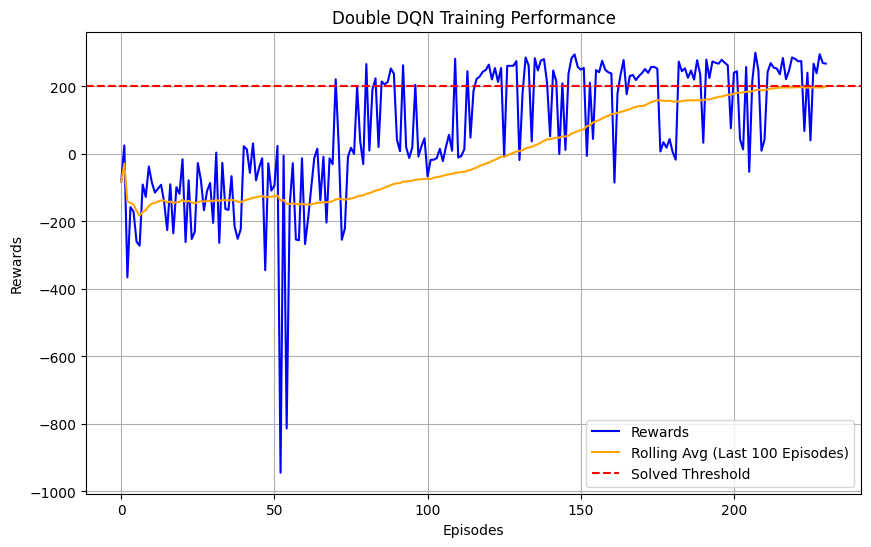

In [10]:
# Plot rewards with rolling average
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards, label='Rewards', color='blue')
plt.plot(rolling_avg_rewards, label='Rolling Avg (Last 100 Episodes)', color='orange')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('Double DQN Training Performance')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

In [13]:
# Testing for 10 episodes
start_time = time.time()

for e_test in range(10):  # Run 10 test episodes
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    steps = 0
    while True:
        # Use the trained model for testing
        action_vals = model.predict(state, verbose=0)  # Predict action values
        action = np.argmax(action_vals[0])  # Choose the action with the highest Q-value

        next_state, reward, done, _, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward
        state = next_state
        steps = steps + 1

        if done:
            print(f"Test Episode: {e_test + 1}/50, Reward: {total_reward:.2f}, Steps: {steps:3}")
            break

end_time = time.time()
testing_duration = (end_time - start_time) / 60  # Convert to minutes
print(f"Testing completed in {testing_duration:.2f} minutes")


Test Episode: 1/50, Reward: 274.00, Steps: 197
Test Episode: 2/50, Reward: 276.03, Steps: 261
Test Episode: 3/50, Reward: 269.09, Steps: 364
Test Episode: 4/50, Reward: 37.51, Steps: 177
Test Episode: 5/50, Reward: 274.41, Steps: 212
Test Episode: 6/50, Reward: 252.68, Steps: 256
Test Episode: 7/50, Reward: 255.44, Steps: 233
Test Episode: 8/50, Reward: 253.26, Steps: 205
Test Episode: 9/50, Reward: 291.58, Steps: 272
Test Episode: 10/50, Reward: 239.04, Steps: 237
Testing completed in 1.98 minutes


In [14]:
# Test the trained agent with video rendering
# This code is very convenient if you are using colab
env = gym.make('LunarLander-v3', render_mode='rgb_array')  # Enable RGB rendering
frames = []  # Store frames for visualization

# Render a single test episode
state, _ = env.reset()
state = np.reshape(state, [1, state_size])
tot_rewards = 0

while True:
    # Use the trained model for action
    action_vals = model.predict(state, verbose=0)  # Predict action values
    action = np.argmax(action_vals[0])  # Choose the action with the highest Q-value

    next_state, reward, done, _, _ = env.step(action)
    frames.append(env.render())  # Save frame for rendering later
    next_state = np.reshape(next_state, [1, state_size])
    tot_rewards += reward
    state = next_state

    if done:
        print(f"Rendered Test Episode Reward: {tot_rewards:.2f}")
        break

env.close()

# Save the rendered episode as a GIF
def save_frames_as_gif(frames, path='./', filename='lunarlander_ddqn1.gif'):
    images = [Image.fromarray(frame) for frame in frames]
    gif_path = os.path.join(path, filename)
    images[0].save(gif_path, save_all=True, append_images=images[1:], duration=50, loop=0)
    print(f"Saved GIF to: {gif_path}")

save_frames_as_gif(frames, filename="lunarlander_ddqn1.gif")


Rendered Test Episode Reward: 248.29
Saved GIF to: ./lunarlander_ddqn1.gif


In [15]:
import session_info
session_info.show(html=False)

-----
PIL                 11.0.0
gymnasium           1.0.0
keras               3.6.0
matplotlib          3.9.2
numpy               1.26.4
session_info        1.0.0
tensorflow          2.17.1
-----
IPython             8.28.0
jupyter_client      8.6.3
jupyter_core        5.7.2
-----
Python 3.12.3 (main, Nov  6 2024, 18:32:19) [GCC 13.2.0]
Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2024-12-10 15:28
